In [2]:
 Changes="""Date Aug 29, '23
 1.[done] Add Capex for PHS https://atb.nrel.gov/electricity/2022/utility-scale_battery_storage
 2.[done] Make PHS capacity 50% of RE capacity
 3. 

 Question:
 1. Add reserve [not done yet]

 References:
 1. NGCC Statup cost: https://www.cmu.edu/ceic/assets/docs/publications/phd-dissertations/2015/david-luke-oates-phd-thesis-2015.pdf
 """

In [3]:
# Import packages
import cvxpy as cp
import gurobipy
import numpy as np
import pandas as pd
import os
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tabulate import tabulate

pd.options.display.float_format = '{:.4f}'.format
print(cp.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']


In [ ]:
#DO NOT CHANGE THIS
#This cell is tagged as a 'parameter' so that papermill can override the values and run this notebook
n = 0
p = 0

In [4]:
#load all relevent input data 
path=os.getcwd()
gen_info = pd.read_csv(path+"/data/"+"Generators_data_geothermal.csv")   #has data on cost and engineering charactristics of all the different kinds of generators 
fuels = pd.read_csv(path+"/data/"+"Fuels_data.csv") #has details on fuel costs
# loads = pd.read_csv(path+"/data/"+"Demand.csv")     #load data hourly
daily_ng_price=pd.read_csv(path+"/data/"+"daily_ng_price.csv")    #NG cost daily series
gen_variable = pd.read_csv(path+"/data/"+"Generators_variability_geothermal.csv")  #CF for all generators, added geothermal
load_yearly=pd.read_csv(path+"/data/"+"demand_for_expansion.csv")
solar_wind_variablity_yearly=pd.read_csv(path+"/data/"+"wind_solar_for_expansion.csv")

# n=0                                          #uncomment and vary this for testing within notebook
T_period = range(n * 24 + 1, (n + 1) * 24 + 1)    #isolate hours and other relevant data for day 'n'
loads = load_yearly[load_yearly['Hour'].isin(T_period)].reset_index(drop=True)
loads['Hour'] = range(1, 25)                      #renumber 'Hours' column for single UC run from 1-24

#Isolate wind and solar hourly CF factors for day 'n'
wind_solar_T_period=solar_wind_variablity_yearly[solar_wind_variablity_yearly['Hour'].isin(T_period)].reset_index(drop=True)
hour_index=wind_solar_T_period["Hour"]  #to be used later in building transposed_df

#replace wind and solar hourly CF factors in gen_variable
gen_variable["WEC_SDGE_onshore_wind_turbine_1.0"]=wind_solar_T_period["Wind"]
gen_variable["WEC_SDGE_solar_photovoltaic_1.0"]=wind_solar_T_period["Solar"]

# Assigns ng_fuel cost with the nth day's NG cost
idx = fuels.loc[fuels['Fuel'] == 'pacific_naturalgas'].index[0]
value_to_assign = daily_ng_price.loc[daily_ng_price['day'] == n, 'Cost_per_MMBtu'].iloc[0]
fuels.at[idx, 'Cost_per_MMBtu'] = value_to_assign

In [89]:
#build long-form input table

# (1) Rename all columns to lowercase (by convention)
for data in [gen_info, fuels, loads, gen_variable]:
    data.columns = data.columns.str.lower()

# (2) Keep columns relevant to our UC model 
gen_info = gen_info.iloc[:, 0:26]

#(3) Load in fuel costs and add to data frame
gen_df = gen_info.merge(fuels, on="fuel", how="outer").sort_values(by="r_id").reset_index(drop=True)
gen_df.rename({'cost_per_mmbtu': 'fuel_cost'}, axis=1, inplace=True)

#(4) Create "is_variable" column to indicate if this is a variable generation source (e.g. wind, solar)
gen_df["is_variable"] = False
gen_df.loc[
    gen_df["resource"].isin(["onshore_wind_turbine","small_hydroelectric","solar_photovoltaic"]), 
    "is_variable"] = True

#(5) Create full name of generator (including geographic location and cluster number)
#  for use with variable generation dataframe
gen_df["gen_full"] = gen_df["region"] + "_" + gen_df["resource"] + "_" + gen_df["cluster"].astype(str)
gen_df["gen_full"] = gen_df["gen_full"].str.lower()

# (6) Remove generators with no capacity (e.g. new build options that we'd use if this was capacity expansion problem)
gen_df = gen_df[gen_df["existing_cap_mw"] > 0].reset_index(drop=True)

#(7) Modify load and variable generation dataframes
# no need for time conversion
# 2. Convert from "wide" to "long" format
#NOTE: Below is unrelated to gen_df['gen_full']
gen_variable_long = pd.melt(gen_variable, id_vars=["hour"], var_name='gen_full', value_name='cf')


"""I wrote the codebloack below so that I can distribute between the capacities 
of various generators. Mainly my aim was to keep net capacity unchanged and vary 
shares of VRE and firm capacity. Vary 'p' to obtain varying percentage of firm and renewable resource. 

p=0.5 is 50-50 share distribution between VRE and firm

NOTE: Increasing p is increasing VRE
"""

# #net capacity is all of solar, wind, firm included
net_cap=7746   
# p=0.3    #uncomment and vary this for testing within notebook
q=1-p

for ii in range(21):
    if gen_df['resource'][ii]=='geothermal':
        gen_df['existing_cap_mw'][ii]=(net_cap*q)/2     
    elif gen_df['resource'][ii]=='natural_gas_fired_combined_cycle':
        gen_df['existing_cap_mw'][ii]=(net_cap*q)/2
    elif gen_df['resource'][ii]=='ap300':
        gen_df['existing_cap_mw'][ii]=0  
    elif gen_df['resource'][ii]=='ap600':
        gen_df['existing_cap_mw'][ii]=0   
    elif gen_df['resource'][ii]=='solar_photovoltaic':
        gen_df['existing_cap_mw'][ii]=(net_cap*p)/2
    elif gen_df['resource'][ii]=='onshore_wind_turbine':
        gen_df['existing_cap_mw'][ii]=(net_cap*p)/2
    else:
        print('done!')

"""baseload is not the theoretical baseload, but the 'dispatchable' we need. 
Across geothermal, NGCC and Nuclear I am keeping the baseload value constant and adding on top solar and wind
to satisfy the scenario %es"""

# peak_load=10778 
# baseload=10000

# for ii in range(21):
#     if gen_df['resource'][ii]=='geothermal':
#         gen_df['existing_cap_mw'][ii]=baseload*0.05
#     elif gen_df['resource'][ii]=='natural_gas_fired_combined_cycle':
#         gen_df['existing_cap_mw'][ii]=baseload*0.9
#     elif gen_df['resource'][ii]=='Nuclear':
#         gen_df['existing_cap_mw'][ii]=baseload*0.05
#     elif gen_df['resource'][ii]=='ap300':
#         gen_df['existing_cap_mw'][ii]=0
#     elif gen_df['resource'][ii]=='ap600':
#         gen_df['existing_cap_mw'][ii]=0   
#     elif gen_df['resource'][ii]=='solar_photovoltaic':
#         gen_df['existing_cap_mw'][ii]=peak_load*0.1
#     elif gen_df['resource'][ii]=='onshore_wind_turbine':
#         gen_df['existing_cap_mw'][ii]=peak_load*0.1
#     else:
#         print('done!')
"""diff begin"""
#Makes PHS capacity 50% of RE capacity
gen_df.loc[gen_df['resource'] == 'hydroelectric_pumped_storage', 'existing_cap_mw'] = \
0.5*(gen_df.loc[gen_df['resource'] == 'onshore_wind_turbine', 'existing_cap_mw'].mean() + \
    gen_df.loc[gen_df['resource'] == 'solar_photovoltaic', 'existing_cap_mw'].mean())
"""diff end"""

#removes all gen with 0 capacities
gen_df = gen_df[gen_df["existing_cap_mw"] > 0].reset_index(drop=True)

#rename 'r_id' column depending on how many generators are left
for ii in range(gen_df.shape[0]):
    gen_df['r_id'][ii]=ii+1

"""diff begin"""
#Amortize CAPEX as a 'per day' cost so as to add to the objective as a fixed cost 
n_year=1
gen_df.rename({'capex_per_kw': 'amortized_capex_per_mw'}, axis=1, inplace=True)
gen_df['amortized_capex_per_mw']=gen_df['amortized_capex_per_mw']/(n_year*365*1000)
# print(gen_df)

#SC: OPEX hasant been amortized yet
"""diff end"""


#creates summary table to indicate final capacity percentages of each generatoe type 
gen_summary=gen_df.groupby(['resource']).sum()
gen_summary['percentage_cap']=gen_summary['existing_cap_mw']/sum(gen_summary['existing_cap_mw'])*100
print(tabulate(gen_df[["r_id","resource","existing_cap_mw"]], headers='keys', tablefmt='grid'))
print(tabulate(gen_summary[[ "percentage_cap"]], headers='keys', tablefmt='fancy_grid'))
# print(int(gen_df.loc[gen_df['resource'] == 'hydroelectric_pumped_storage', 'existing_cap_mw'][1]))

done!
done!
+----+--------+----------------------------------+-------------------+
|    |   r_id | resource                         |   existing_cap_mw |
+====+========+==================================+===================+
|  0 |      1 | geothermal                       |            2711.1 |
+----+--------+----------------------------------+-------------------+
|  1 |      2 | hydroelectric_pumped_storage     |            1161.9 |
+----+--------+----------------------------------+-------------------+
|  2 |      3 | natural_gas_fired_combined_cycle |            2711.1 |
+----+--------+----------------------------------+-------------------+
|  3 |      4 | Nuclear                          |             500   |
+----+--------+----------------------------------+-------------------+
|  4 |      5 | onshore_wind_turbine             |            1161.9 |
+----+--------+----------------------------------+-------------------+
|  5 |      6 | solar_photovoltaic               |            116

<ipython-input-89-6497c41307bf>:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-89-6497c41307bf>:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-89-6497c41307bf>:57: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-89-6497c41307bf>:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

# **OPTIMIZATION PIPELINE**

In [90]:
# Define sets based on data

G = gen_df["r_id"].tolist() # set of all generators 
G_thermal = gen_df[gen_df["up_time"] > 0]["r_id"].tolist() # thermal
G_nonthermal = gen_df[gen_df["up_time"] == 0]["r_id"].tolist() # non-thermal
G_var = gen_df[gen_df["is_variable"] == 1]["r_id"].tolist() # variable (renewable)
G_phs = gen_df[gen_df["resource"] == "hydroelectric_pumped_storage" ]["r_id"].tolist() # non-variable and non-thermal
G_nonphs=list(set(G)-set(G_phs))
G_nt_nonvar = G_nonthermal + G_phs # non-variable and non-thermal


# length of UC, vary this for nuclear such that T >= max(Deadtime)
T = loads["hour"].tolist()
T_red = T[:-1]

# Generator capacity factor time series for variable generators
gen_var_cf = gen_variable_long.merge(
    gen_df.loc[gen_df["is_variable"] == 1, ["r_id", "gen_full", "existing_cap_mw"]], 
    on="gen_full", how="inner")


### VARIABLES ###
GEN = cp.Variable((len(G), len(T))) # generation across the fleet
COMMIT = cp.Variable((len(G), len(T)), boolean=True) # commitment status (Bin=binary) for thermals
START = cp.Variable((len(G), len(T)), boolean=True) # startup decision for thermals
SHUT = cp.Variable((len(G), len(T)), boolean=True) # shutdown decision for thermals
GENAUX=cp.Variable((len(G), len(T))) #Auxillary variable for introducing ramp constraints

#PHS variables
SOC = cp.Variable(len(T)) #State-of-charge
CHARGE = cp.Variable(len(T))
DISCHARGE = cp.Variable(len(T))
CHARGE_MODE = cp.Variable(len(T), boolean=True) #binary variable to avoid charging and discharging at the same time



In [91]:
### OBJECTIVE ###
# Sum of variable costs (G_nonvar and G_var: all) + start-up costs (G_thermal) for all generators and time periods
fixed_cost = np.dot(gen_df['amortized_capex_per_mw'], gen_df['existing_cap_mw'])
cost = cp.sum(GEN.T @ (np.multiply(gen_df["heat_rate_mmbtu_per_mwh"], gen_df["fuel_cost"]) + gen_df["var_om_cost_per_mwh"])) + \
       cp.sum(START.T @ np.multiply(gen_df["existing_cap_mw"], gen_df["start_cost_per_mw"])) + \
       fixed_cost


### CONSTRAINT SET ###
constraints = []

#1. SUPPLY-DEMAND BALANCE
constraints.append(cp.sum(GEN, axis=0) == loads["demand"])

# 2.  CAPACITY CONSTRAINTS
# 2.1. thermal generators requiring commitment (nuclear,gas, etc)
#Pmin_g*COMMIT_gt<=Pgt<=Pmax_g*COMMIT_gt
for i in G_thermal:
    constraints.append(
        GEN[i-1, :] >= COMMIT[i-1, :] * \
            gen_df[gen_df["r_id"] == i]["existing_cap_mw"] * gen_df[gen_df["r_id"] == i]["min_power"])
    constraints.append(
        GEN[i-1, :] <= COMMIT[i-1, :] * gen_df[gen_df["r_id"] == i]["existing_cap_mw"])

# 2.2. non-variable generation not requiring commitment (hydroelectric,geothermal, etc)
for i in G_phs:
    constraints.append(
        GEN[i-1, :] <= gen_df[gen_df["r_id"] == i]["existing_cap_mw"])

# 2.3. variable generation, accounting for hourly capacity factor (wind, solar, etc)
for i in G_var:
        constraints.append(
            GEN[i-1, :] <= gen_var_cf[gen_var_cf["r_id"] == i]["existing_cap_mw"] * \
                gen_var_cf[gen_var_cf["r_id"] == i]["cf"])
        
#2.4. Capacity non-negativity of generation for all generators apart from PHS
for i in G_nonphs:
    constraints.append(GEN[i-1, :] >= 0)
    constraints.append(GEN[i-1, :] <= gen_df[gen_df["r_id"] == i]["existing_cap_mw"])

    
# 3. COMMITMENT CONSTRAINTS (for G_themral)
# 3.1. Minimum up time (if there is a start decision value)
for i in G_thermal:
        for t in T: # note: T is from 1 to 24
            constraints.append(COMMIT[i-1, t-1] >= \
                               sum(START[i-1, max(0, (t-gen_df[gen_df["r_id"] == i]["up_time"].any()-1)):t]
                                  ))
# 3.2. Minimum down time (if there is a down decision value)
for i in G_thermal:
    for t in T: # note: T is from 1 to 24
            constraints.append(1 - COMMIT[i-1, t-1] >= \
                               sum(SHUT[i-1, max(0, (t-gen_df[gen_df["r_id"] == i]["down_time"].any()-1)):t]
                                ))
# 3.3. Commitment state
for i in G_thermal:
    for t in T_red: # note: T_red is from 1 to 23
            constraints.append(COMMIT[i-1, t] - COMMIT[i-1, t-1] == START[i-1, t] - SHUT[i-1, t])

#3.4 For non-thermals, COMMIT/START/SHUT should be 0 SC: Isint this redundant?
for i in G_nonthermal:
    constraints.append(COMMIT[i-1, :] == 0)
    constraints.append(START[i-1, :] == 0)
    constraints.append(SHUT[i-1, :] == 0)


#4. RAMP CONSTRAINTS (SC: Fairly confident about all the ramp constraints, but check again.)
#4.1. For Committed thermal generators, GENAUX is generation above minimum output
for i in G_thermal:
    for t in T:
        existing_cap_mw = gen_df.loc[gen_df['r_id'] == i, 'existing_cap_mw'].values[0]
        min_power = gen_df.loc[gen_df['r_id'] == i, 'min_power'].values[0]
        constraints.append(GENAUX[i-1, t-1] == GEN[i-1, t-1] - COMMIT[i-1, t-1] * existing_cap_mw * min_power)

#4.2. Ramp up constraint for G_thermal
for i in G_thermal:
    for t in range(len(T_red)):
        existing_cap_mw = gen_df.loc[gen_df['r_id'] == i, 'existing_cap_mw'].values[0]
        ramp_up_percentage = gen_df.loc[gen_df['r_id'] == i, 'ramp_up_percentage'].values[0]
        constraints.append(GENAUX[i-1, t] - GENAUX[i-1, t-1] <= existing_cap_mw * ramp_up_percentage)        

#4.3. Ramp down constraint for G_thermal        
for i in G_thermal:
    for t in range(len(T_red)):
        existing_cap_mw = gen_df.loc[gen_df['r_id'] == i, 'existing_cap_mw'].values[0]
        ramp_dn_percentage = gen_df.loc[gen_df['r_id'] == i, 'ramp_dn_percentage'].values[0]
        constraints.append(GENAUX[i-1, t-1] - GENAUX[i-1, t] <= existing_cap_mw * ramp_dn_percentage)

#4.4. Ramp up constraint for G_nonthermal (SC: Might be redundant? since ramp percentages is 1?)
for i in G_nonthermal:
    for t in range(len(T_red)):
        existing_cap_mw = gen_df.loc[gen_df['r_id'] == i, 'existing_cap_mw'].values[0]
        ramp_up_percentage = gen_df.loc[gen_df['r_id'] == i, 'ramp_up_percentage'].values[0]
        constraints.append(GEN[i-1, t] - GEN[i-1, t-1] <= existing_cap_mw * ramp_up_percentage) 

#4.5. Ramp down constraint for G_nonthermal (SC: Might be redundant? since ramp percentages is 1?)        
for i in G_nonthermal:
    for t in range(len(T_red)):
        existing_cap_mw = gen_df.loc[gen_df['r_id'] == i, 'existing_cap_mw'].values[0]
        ramp_dn_percentage = gen_df.loc[gen_df['r_id'] == i, 'ramp_dn_percentage'].values[0]
        constraints.append(GEN[i-1, t-1] - GEN[i-1, t] <= existing_cap_mw * ramp_dn_percentage)    

#SC: Reserve constraints?
        
#5. PHS CONSTRAINTS [BATTERY]:
one_way_efficiency = 0.84
duration_hr = 10
power_capacity = int(gen_df.loc[gen_df['resource'] == 'hydroelectric_pumped_storage', 'existing_cap_mw'][1])
energy_capacity = power_capacity * duration_hr # MWh
#5.1. PHS1. charge/discharge power constraints
constraints.append(CHARGE >= 0)
constraints.append(CHARGE <= power_capacity)
constraints.append(DISCHARGE >= 0)
constraints.append(DISCHARGE <= power_capacity)
#5.2. PHS2. energy constraint
constraints.append(SOC >= 0)
constraints.append(SOC <= energy_capacity)
#5.3. PHS3. state constraint
for t in range(len(T)-1):
    constraints.append(SOC[t+1] == SOC[t] + (CHARGE[t+1] * one_way_efficiency) - (DISCHARGE[t+1] / one_way_efficiency))
#5.4. PHS4. start/end SOC constraint
constraints.append(SOC[-1] == 0.5 * energy_capacity)
constraints.append(SOC[0] == 0.5 * energy_capacity)
#5.5. PHS5: CHARGE - DISCHARGE = GEN for PHS
for i in G_phs:
    constraints.append(GEN[i-1, :] == DISCHARGE - CHARGE)
#5.6. Add constraints linking CHARGE_MODE to CHARGE and DISCHARGE
for t in range(len(T)):
    constraints.append(CHARGE[t] <= CHARGE_MODE[t] * power_capacity) # Charge only if CHARGE_MODE[t] = 1
    constraints.append(DISCHARGE[t] <= (1 - CHARGE_MODE[t]) * power_capacity) # Discharge only if CHARGE_MODE[t] = 0

In [165]:
#Reserve constraints:

RESUP=cp.Variable((len(G), len(T))) 
RESDN=cp.Variable((len(G), len(T)))

ResReqUp = {}
ResReqDn = {}


for i in T:
    demand = loads.loc[loads['hour'] == i, 'demand'].iloc[0]
    ResReqUp[i] = 300 + 0.05 * demand
    ResReqDn[i] = 0 + 0.05 * demand


# Existing capacity and minimum power (from a DataFrame, modify as needed)
existing_cap_mw = gen_df.set_index('r_id')['existing_cap_mw'].to_dict()
min_power = gen_df.set_index('r_id')['min_power'].to_dict()

# Reserve Up Capacity Constraint
for i in G_thermal:
    for t in T:
        constraints.append(RESUP[i-1, t-1] <= COMMIT[i-1, t-1] * existing_cap_mw[i] - GEN[i-1, t-1])

# Reserve Down Capacity Constraint
for i in G_thermal:
    for t in T:
        constraints.append(RESDN[i-1, t-1] <= GEN[i-1, t-1] - COMMIT[i-1, t-1] * existing_cap_mw[i] * min_power[i])

# Convert relevant DataFrame columns to dictionaries
ramp_up_percentage = gen_df.set_index('r_id')['ramp_up_percentage'].to_dict()
ramp_dn_percentage = gen_df.set_index('r_id')['ramp_dn_percentage'].to_dict()

# Reserve Up Ramp Constraint
for i in G_thermal:
    for t in T:
        constraints.append(RESUP[i-1, t-1] <= existing_cap_mw[i] * ramp_up_percentage[i])

G_thermal_np = np.array(G_thermal, dtype=int)-1


# Overall Reserve Up Requirement Constraint
for t in T:
    constraints.append(cp.sum(RESUP[G_thermal_np, t-1]) >= ResReqUp[t])

# Overall Reserve Down Requirement Constraint
for t in T:
    constraints.append(cp.sum(RESDN[G_thermal_np, t-1]) >= ResReqDn[t])

# Enforce RESUP to be positive
for i in G_thermal:
    for t in T:
        constraints.append(RESUP[i-1, t-1] >= 0)

# Enforce RESDN to be positive
for i in G_thermal:
    for t in T:
        constraints.append(RESDN[i-1, t-1] >= 0)

In [169]:
"""Solve the problem""" 
prob = cp.Problem(cp.Minimize(cost), 
                  constraints)
env = gurobipy.Env()
env.setParam('MIPGap', 0.0001)  #adjust for precision
prob.solve(solver=cp.GUROBI)


"""Save results"""
print("\nThe optimal value is", prob.value)
resup_result_df = pd.DataFrame(np.row_stack(RESUP.value))
resup_result_df.index.name = 'generator'
resdn_result_df = pd.DataFrame(np.row_stack(RESDN.value))
resdn_result_df.index.name = 'generator'
gen_result_df = pd.DataFrame(np.row_stack(GEN.value))
gen_result_df.index.name = 'generator'
commit_result_df = pd.DataFrame(np.row_stack(COMMIT.value))
commit_result_df.index.name = 'generator'
cost = prob.value

# Calculate curtailment = available wind and/or solar output that had to be wasted due to operating constraints
gen_result_df_long = gen_result_df.copy(deep=True)
gen_result_df_long["r_id"] = gen_df["r_id"]
gen_result_df_long = pd.melt(gen_result_df_long, id_vars=["r_id"], var_name='hour', value_name='gen')
gen_result_df_long["hour"] = gen_result_df_long["hour"] + 1 
curtail = gen_var_cf.merge(gen_result_df_long, how="inner", on=["r_id", "hour"])
curtail["curt"] = curtail["cf"] * curtail["existing_cap_mw"] - curtail["gen"]

#PHS Results
gen_phs = gen_result_df_long[gen_result_df_long["r_id"] == 2].reset_index(drop=True)
gen_phs["charge"] = CHARGE.value
gen_phs["discharge"] = DISCHARGE.value
gen_phs["soc"]=SOC.value

Academic license - for non-commercial use only - expires 2024-07-26
Using license file /Users/shinychoudhury/gurobi.lic
Parameter MIPGap unchanged
   Value: 0.0001  Min: 0.0  Max: inf  Default: 0.0001

The optimal value is 44224.784884927685


In [175]:
#Reserve results
#resup
resup_result_df_grouped = resup_result_df.copy(deep=True)
resup_result_df_grouped["resource"] = gen_df["resource"]
resup_result_df_grouped = resup_result_df_grouped.groupby('resource', as_index=False).sum()

resup = resup_result_df_grouped.transpose()
resup.columns = resup.iloc[0]
resup = resup[1:]
resup['hour']=hour_index


#resdn
resdn_result_df_grouped = resdn_result_df.copy(deep=True)
resdn_result_df_grouped["resource"] = gen_df["resource"]
resdn_result_df_grouped = resdn_result_df_grouped.groupby('resource', as_index=False).sum()

resdn = resdn_result_df_grouped.transpose()
resdn.columns = resdn.iloc[0]
resdn = resdn[1:]
resdn['hour']=hour_index

resup.to_csv(f'resup_{n}.csv')  #connected to master_UC_Geothermal.ipynb
resdn.to_csv(f'resdn_{n}.csv')  #connected to master_UC_Geothermal.ipynb

resource,Nuclear,geothermal,hydroelectric_pumped_storage,natural_gas_fired_combined_cycle,onshore_wind_turbine,solar_photovoltaic,hour
0,0.0000,647.5136,0.0000,0.0000,0.0000,0.0000,1
1,0.0000,873.6222,0.0000,0.0000,0.0000,0.0000,2
2,0.0000,412.9042,0.0000,0.0000,0.0000,0.0000,3
3,0.0000,236.5900,0.0000,0.0000,0.0000,0.0000,4
4,0.0000,409.0850,0.0000,0.0000,0.0000,0.0000,5
5,0.0000,319.8171,0.0000,0.0000,0.0000,0.0000,6
6,0.0000,96.4500,0.0000,0.0000,0.0000,0.0000,7
7,0.0000,85.7500,0.0000,0.0000,0.0000,0.0000,8
8,0.0000,77.7500,0.0000,0.0000,0.0000,0.0000,9
9,0.0000,0.0000,0.0000,73.6500,0.0000,0.0000,10


Generation percentage by resource: 
 resource
Nuclear                             4.9396
geothermal                         19.1997
hydroelectric_pumped_storage        8.0412
natural_gas_fired_combined_cycle   55.0398
onshore_wind_turbine                2.8320
solar_photovoltaic                  9.9477
dtype: object
Net-supply subtracted to net demand is: 0.0
Net curtailment: 1923.4355327846972


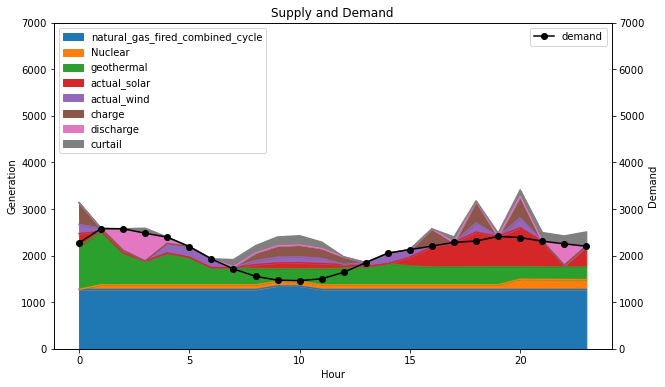

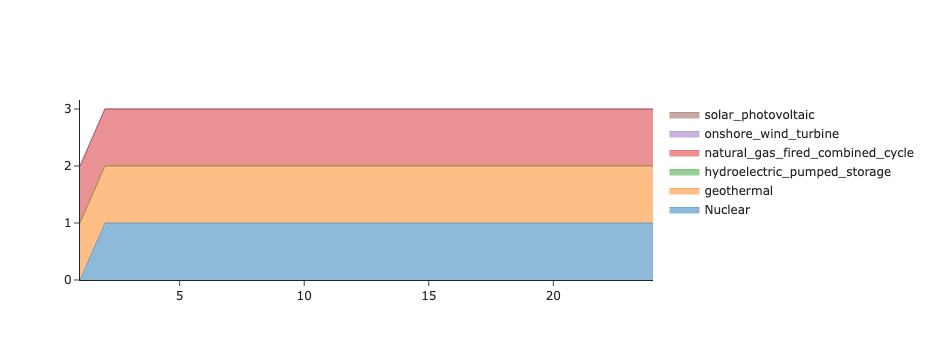

resource,Nuclear,geothermal,hydroelectric_pumped_storage,natural_gas_fired_combined_cycle,onshore_wind_turbine,solar_photovoltaic,actual_solar,actual_wind,charge,discharge,soc,demand,net_supply,curtail,Hour
0,0.0000,918.6236,-464.7600,1274.2170,34.4436,511.4757,279.0957,-197.9364,464.7600,0.0000,5805.0000,2274,2274.0000,0.0000,1
1,100.0000,1144.7322,0.0000,1274.2170,62.0508,0.0000,0.0000,62.0508,0.0000,0.0000,5805.0000,2581,2581.0000,0.0000,2
2,100.0000,684.0142,464.7600,1274.2170,53.0088,0.0000,0.0000,53.0088,0.0000,464.7600,5251.7143,2576,2576.0000,0.0000,3
3,100.0000,507.7000,600.0830,1274.2170,0.0000,0.0000,0.0000,0.0000,0.0000,600.0830,4537.3298,2482,2482.0000,105.5027,4
4,100.0000,680.1950,135.3230,1274.2170,206.2651,0.0000,0.0000,206.2651,0.0000,135.3230,4376.2311,2396,2396.0000,0.0000,5
5,100.0000,590.9271,0.0000,1274.2170,227.8559,0.0000,0.0000,227.8559,0.0000,0.0000,4376.2311,2193,2193.0000,0.0000,6
6,100.0000,367.5600,0.0000,1274.2170,187.2230,0.0000,0.0000,187.2230,0.0000,0.0000,4376.2311,1929,1929.0000,2.7252,7
7,100.0000,356.8600,-16.0770,1274.2170,0.0000,0.0000,-8.0385,-8.0385,16.0770,0.0000,4389.7357,1715,1715.0000,150.2474,8
8,100.0000,348.8600,-168.0770,1274.2170,0.0000,0.0000,-84.0385,-84.0385,168.0770,0.0000,4530.9204,1555,1555.0000,152.7289,9
9,100.0000,271.1100,-245.9770,1347.8670,0.0000,0.0000,-122.9885,-122.9885,245.9770,0.0000,4737.5411,1473,1473.0000,189.1480,10


In [172]:
"""PLOTTING GENERATION"""

gen_result_df_grouped = gen_result_df.copy(deep=True)
gen_result_df_grouped["resource"] = gen_df["resource"]
gen_result_df_grouped = gen_result_df_grouped.groupby('resource', as_index=False).sum()


#df simply is a copy of the results to work with for plotting etc
df=gen_result_df_grouped

# Transpose the DataFrame and set the first row as column names
transposed_df = df.transpose()
transposed_df.columns = transposed_df.iloc[0]
transposed_df = transposed_df[1:]
print("Generation percentage by resource: \n",100*transposed_df.abs().sum()/(transposed_df.abs().sum().sum()))

"""the hourly hydroelectric_pumped_storage values correspond to the net DISCHARGE-CHARGE 
values and the negative values are when the battery is charging and positive for discharging. 
Since the optimizations objective is to minimize the net schedulling cost, the battery charges
when low cost extra energy is available, which in our case is when solar and wind, which has 0 variable cost produces energy. 
Even though we have no constrian that the battery charge only when excess renewable is available,
it coincides.

The actual_solar that goes to fulfilling demand is the solar output of which we subtract battery energy when its charging, which is
PHS capacity when it is negative, and leave it when not"""

#in the next two operations i am dividing chargeing energy by half and subtracting it from solar and wind coz we cant reason where actually the charging happened from
transposed_df["actual_solar"]=transposed_df.apply(lambda row: row['solar_photovoltaic'] + (row['hydroelectric_pumped_storage']/2) if row['hydroelectric_pumped_storage'] < 0 else row['solar_photovoltaic'], axis=1)
transposed_df["actual_wind"]=transposed_df.apply(lambda row: row['onshore_wind_turbine'] + (row['hydroelectric_pumped_storage']/2) if row['hydroelectric_pumped_storage'] < 0 else row['onshore_wind_turbine'], axis=1)
transposed_df["charge"]=gen_phs["charge"]
transposed_df["discharge"]=gen_phs["discharge"]
transposed_df["soc"]=gen_phs["soc"]
transposed_df["demand"]=loads.demand
transposed_df["net_supply"]=transposed_df[["geothermal", "natural_gas_fired_combined_cycle", "Nuclear", "onshore_wind_turbine","hydroelectric_pumped_storage","solar_photovoltaic"]].sum(axis=1)
transposed_df["curtail"]=curtail["curt"]
transposed_df["Hour"]=hour_index    #to finally collate results on master_df

print("Net-supply subtracted to net demand is:",sum(transposed_df["net_supply"])-sum(transposed_df["demand"]))
print("Net curtailment:",sum(transposed_df["curtail"]))

"""GEN Stackplot"""
plottable=transposed_df[["natural_gas_fired_combined_cycle",  "Nuclear", "geothermal", "actual_solar", "actual_wind","charge","discharge","curtail"]]


# Set the figure size
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the stacked area chart
plottable.abs().plot.area(stacked=True, ax=ax1) #NOTE: Plots only abs() values of generations

# Create a twin axes sharing the x-axis
ax2 = ax1.twinx()

# Plot the load column on the secondary y-axis
transposed_df['demand'].plot(ax=ax2, color='black', marker='o')

# Set labels and title
ax1.set_xlabel('Hour')
ax1.set_ylabel('Generation')
ax2.set_ylabel('Demand')
plt.title('Supply and Demand')

ax1.set_ylim([0, 7000])
ax2.set_ylim([0, 7000])

# Show the legend for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()

"""Commit stackplot"""
# Plot a stacked area of commitment
# Group by commit_result_df for plotting
commit_result_df_grouped = commit_result_df.copy(deep=True)
commit_result_df_grouped["resource"] = gen_df["resource"]
commit_result_df_grouped = commit_result_df_grouped.groupby('resource', as_index=False).sum()

fig = go.Figure()
for index, row in commit_result_df_grouped.iterrows():
    values = row.drop("resource").tolist()  # Exclude the "resource" column
    fig.add_trace(go.Scatter(x=loads["hour"], y=values,
                             mode='lines', line=dict(width=0.5),
                             name=row["resource"], stackgroup='one'))
fig.update_layout(template="simple_white")
fig.show()

transposed_df.to_csv(f'transposed_df_{n}.csv')  #connected to master_UC_Geothermal.ipynb

Electricity price at each hour will be the clearing price after metrit ordering the generators to fulfill demand $D_{t}$ at time $t$. We are amortizing the $Capex_{g}$ which is in  $\$$/kW to an hourly fixed cost in $\$$/MWh as below:
$$FC_{g}=\frac{Capex_{g}}{365 \times 24 \times 1000}$$
The variable cost of generator $g$ at each time $t$ is:
$$VC_{g}=VarOM_{g}+HeatRate_{g} \times FuelCost_{g}$$
The hourly cost of electricity from each generator then will be:
$$EC_{g}=FC_{g}+VC_{g}$$

The market will clear at the cost of the most expensive generator used to fulfill demand:
$$EC^{*}_{t}=max(EC_{g})\quad \forall g$$

Algorithm:
1. Compute $EC_{g}$ for each generator $g$ and save it
2. At each hour $t$ find the subset of generators $G' \subset G$ which have $GEN_{g,t} > 0$
3. For the subset $G'$ find $EC^{*}_{t}=max(EC_{g})\quad \forall g \in G'$

In [261]:
#fixed cost
fixed_cost_hourly=pd.DataFrame()
fixed_cost_hourly['generator']=gen_df['resource']
fixed_cost_hourly['fixed_cost_$_per_mwh']=(gen_df['amortized_capex_per_mw']*gen_df['existing_cap_mw'])/(24)

#var cost
var_cost_hourly=pd.DataFrame()
var_cost_hourly['generator']=gen_df['resource']
var_cost_hourly['var_cost_$_per_mwh'] = (np.multiply(gen_df["heat_rate_mmbtu_per_mwh"], gen_df["fuel_cost"]) + gen_df["var_om_cost_per_mwh"]).values.reshape(-1, 1)

#total cost
total_cost_hourly=fixed_cost_hourly.copy()
total_cost_hourly.rename({'fixed_cost_$_per_mwh': 'total_cost_$_per_mwh'}, axis=1, inplace=True)
total_cost_hourly['total_cost_$_per_mwh']=fixed_cost_hourly['fixed_cost_$_per_mwh']+var_cost_hourly['var_cost_$_per_mwh']

#Hourly electricity prices
generation_hourly=pd.DataFrame()
generation_hourly['Hour']=hour_index
generation_values=pd.DataFrame(GEN.value.T, columns=gen_df['resource'].values)
generation_values.drop(columns=['hydroelectric_pumped_storage'], inplace=True)
gen_subset=[generation_values.columns[(row > 0)].tolist() for row in generation_values.values]


#For each subset of generators, find the corresponding rows in total_cost_hourly and get the one with the highest cost
highest_costs = []
for subset in gen_subset:
    matching_rows = total_cost_hourly.loc[total_cost_hourly['generator'].isin(subset)]
    highest_cost_row = matching_rows.nlargest(1, 'total_cost_$_per_mwh')
    highest_costs.append(highest_cost_row)

#Convert the list of DataFrames into a single DataFrame
cost_of_elec = pd.DataFrame(pd.concat(highest_costs)).reset_index(drop=True)
cost_of_elec['Hour']=hour_index

cost_of_elec.to_csv(f'cost_of_elec_{n}.csv')
print(fixed_cost_hourly)
# print(var_cost_hourly)
print(total_cost_hourly)
cost_of_elec

                          generator  fixed_cost_$_per_mwh
0                        geothermal                2.7764
1      hydroelectric_pumped_storage                0.1990
2  natural_gas_fired_combined_cycle                0.3971
3              onshore_wind_turbine                0.2601
4                solar_photovoltaic                0.1712
                          generator  total_cost_$_per_mwh
0                        geothermal                3.9364
1      hydroelectric_pumped_storage                0.1990
2  natural_gas_fired_combined_cycle              102.8617
3              onshore_wind_turbine                0.2601
4                solar_photovoltaic                0.1712


,generator,total_cost_$_per_mwh,Hour
0,geothermal,3.9364,1
1,geothermal,3.9364,2
2,geothermal,3.9364,3
3,geothermal,3.9364,4
4,geothermal,3.9364,5
5,geothermal,3.9364,6
6,geothermal,3.9364,7
7,geothermal,3.9364,8
8,geothermal,3.9364,9
9,geothermal,3.9364,10


In [267]:
# cost_of_elec = np.random.normal(50, 20, size=len(transposed_df))
transposed_df['electricity_price'] = cost_of_elec['total_cost_$_per_mwh']
# Initialize the results dataframe
results = pd.DataFrame(columns=["item", "unit", "value"])
# Calculate procurement costs (consumer payments)
procurement_costs = np.dot(transposed_df["demand"], cost_of_elec['total_cost_$_per_mwh'])
results.loc[len(results), :] = ["procurement_costs", "$", procurement_costs]
# Calculate unserved load (MWh)
unserved_load = np.sum(transposed_df["demand"]) - np.sum(transposed_df["net_supply"])
results.loc[len(results), :] = ["unserved_load", "MWh", unserved_load]
# Calculate curtailment (MWh)
curtailed_load = np.sum(transposed_df["curtail"])
results.loc[len(results), :] = ["curtailed_load", "MWh", curtailed_load]
# Calculate system emissions
gas_ef = 0.25  # kgCO2 per kWh, or tCO2 per MWh, can be as a function of gas capacity
system_emission = np.dot(transposed_df["natural_gas_fired_combined_cycle"],
                         gas_ef).sum()
results.loc[len(results), :] = ["system_emission", "tonne CO2", system_emission]
# Calculate carbon costs
carbon_price = 80 # $ per tCO2 (https://tradingeconomics.com/commodity/carbon)
results.loc[len(results), :] = ["carbon_costs", "$", system_emission * carbon_price]
results['day']=n

results.to_csv(f'results_{n}.csv')

,item,unit,value,day
0,procurement_costs,$,197528.6328,0
1,unserved_load,MWh,0.0000,0
2,curtailed_load,MWh,-0.0000,0
3,system_emission,tonne CO2,0.0000,0
4,carbon_costs,$,0.0000,0


In [268]:
# Calculate electricity revenues by technology
summary_by_tech = pd.DataFrame()
summary_by_tech["tech"] = gen_summary.index
summary_by_tech["existing_cap_mw"] = gen_summary["existing_cap_mw"].tolist()
rev_gas = np.dot(transposed_df["natural_gas_fired_combined_cycle"],cost_of_elec['total_cost_$_per_mwh'])
rev_solar = np.dot(transposed_df["solar_photovoltaic"], cost_of_elec['total_cost_$_per_mwh'])
rev_wind = np.dot(transposed_df["onshore_wind_turbine"], cost_of_elec['total_cost_$_per_mwh'])
rev_geo = np.dot(transposed_df["geothermal"], cost_of_elec['total_cost_$_per_mwh'])
rev_nuclear = np.dot(transposed_df["Nuclear"], cost_of_elec['total_cost_$_per_mwh'])
rev_storage = np.dot(transposed_df["hydroelectric_pumped_storage"], cost_of_elec['total_cost_$_per_mwh'])
summary_by_tech["total_electricity_rev_$"] = [rev_geo, rev_nuclear, rev_storage, rev_gas, rev_wind, rev_solar]
summary_by_tech["unit_rev_$_per_mw"] = summary_by_tech["total_electricity_rev_$"] / \
    summary_by_tech["existing_cap_mw"]
# Add capacity payments for each technology
summary_by_tech["capacity_price_$_per_mw_day"] = 28.92
summary_by_tech["adjustment_factor"] = [0.9,0.9, 0.9, 0.9, 0.4, 0.4]
# https://pjm.com/-/media/markets-ops/rpm/rpm-auction-info/2024-2025/2024-2025-base-residual-auction-report.ashx
summary_by_tech["total_capacity_rev_$"] = \
    summary_by_tech["capacity_price_$_per_mw_day"] * \
    summary_by_tech["existing_cap_mw"] * \
    summary_by_tech["adjustment_factor"] * \
    int(len(transposed_df["Hour"]) / 24)
summary_by_tech['day']=n
summary_by_tech
summary_by_tech.to_csv(f'summary_by_tech_{n}.csv')

,tech,existing_cap_mw,total_electricity_rev_$,unit_rev_$_per_mw,capacity_price_$_per_mw_day,adjustment_factor,total_capacity_rev_$,day
0,geothermal,2711.1000,150121.2405,55.3728,28.9200,0.9000,70564.5108,0
1,hydroelectric_pumped_storage,1161.9000,1739.6144,1.4972,28.9200,0.9000,30241.9332,0
2,natural_gas_fired_combined_cycle,2711.1000,0.0000,0.0000,28.9200,0.9000,70564.5108,0
3,onshore_wind_turbine,1161.9000,13795.1558,11.8729,28.9200,0.4000,13440.8592,0
4,solar_photovoltaic,1161.9000,31872.6220,27.4315,28.9200,0.4000,13440.8592,0
